# Modelo y simulación de un PFR (adiabático) 

![newnotebook](./imágenes/PFR.gif)

En un RFP tienen lugar las reacciones elementales en fase gas indicadas en la tabla. El reactor tiene 4 m
de longitud y 0.3 m de diámetro interno. El alimento consiste en una mezcla de $480 kmol·min^{-1}$ de A, $270 kmol·min^{-1}$ de B y $420 kmol·min^{-1$}$ de D. La presión en el reactor es constante e igual a $130 kPa$ y la temperatura de entrada del alimento es $650ºC$. El reactor está refrigerado con agua a una Tw de $10ºC$. El coeficente global de intercambio de calor U entre el reactor y el refrigerante es igual a $25 kJ·s^{-1}·m^{-2}·K^{-1}$.


| $\phantom{m} Reacciones \> Elementales$ | $\phantom{mm} k_0 \> \phantom{m}(s^{-1})\phantom{m}$  | $\phantom{mmm} E \> \phantom{}(kJ·kmol^{-1})$ | $\phantom{mm} H*_{298K} \>\phantom{}(kJ·kmol^{-1})$  |
| :--------------------------: | :--------------:  | :---------------:  | :-----------------------:   |
| $A + B \rightarrow 2 \; C$   | $\:1.9·10^{12}\:$     | $\: 103930 \:$           | $\: -7100     \:$                |
| $C + D \rightarrow E + F$    | $\:6.9·10^{14}\:$     | $\: 176020 \:$           | $\:12300    \:$                 |
| $B + C \rightarrow G$        | $\:1.51·10^{14}\:$    | $\: 148010 \:$           | $\:-9200   \:$                  |
| $D \rightarrow C + H$        | $\:3.2·10^{16}\:$     | $\: 251020 \:$           | $\:13500  \:$                   |
| $C + H \rightarrow D$        | $\:7.1·10^{13}\:$     | $\: 129710 \:$           | $\:-13500\:$                    |
| $2 \; A \rightarrow E$       | $\:7.2·10^{8} \:$     | $\: 42450  \:$           | $\:-5800\:$                     |


Representar gráficamente los perfiles de temperatura y concentración de cada componente en el
reactor.

__Otros datos__

$C_P$ : Capacidad calorífica $(kJ·kmol^{-1}·K^{-1})$

|$\phantom{mm}$ A $\phantom{mm}$|$\phantom{mm}$ B $\phantom{mm}$|$\phantom{mm}$ C $\phantom{mm}$ |$\phantom{mm}$ D $\phantom{mm}$|$\phantom{mm}$ E $\phantom{mm}$|$\phantom{mm}$ F $\phantom{mm}$|$\phantom{mm}$ G $\phantom{mm}$|$\phantom{mm}$ H $\phantom{mm}$|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| 41| 74| 56| 40| 29| 22| 35| 49|

***

# Code

In [1]:
# Librerías a usar

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from __future__ import division

%matplotlib inline

plt.style.use('bmh')

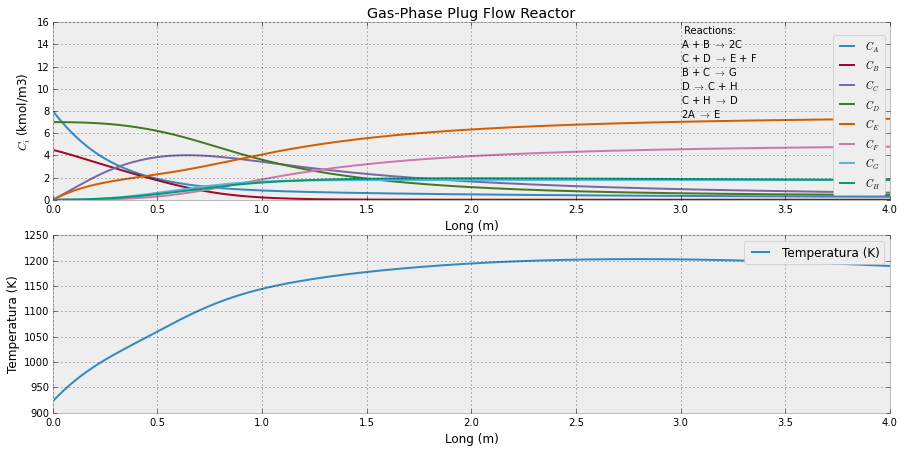

In [30]:
#Constante 
Rg = 8.31

#Factor Pre-exponencial
k = np.array([1.9e12, 6.9e14, 1.5e14, 3.2e16, 7.4e13, 7.2e8]) #s-1
    
#ENERGÍA DE ACTIVACIÓN
Ea = np.array([103930, 176020, 148010, 251020, 129710, 42450]) #kJ/kmol
    
#TERMODINAMIC DATA
    
Tref = 298 #K
    
dHref = np.array([-7100, 12300, -9200, 13500, -13500, -5800]) #kJ/kmol
    
Cp = np.array([41, 74, 56, 40, 29, 22, 35, 49]) #kJ/kmol*K

#DATOS INICIALES DE OPERACIÓN DEL REACTOR
    
P0 = 130 #Pa
T0 = 650+273 #K
    
#DATOS REACTOR
    
L0 = 4 #Longitud del reactor (m)
D = 0.3 #Diámetro (m)
S = np.pi*((D/2)**2) #Sección del tubo (m2)
U = 25 #Coef global de intercambio de calor (kJ/m2·s·K)
  
#ALIMENTO
    
C_A0 = 480/60
C_B0 = 270/60
C_D0 = 420/60
    
n0 = np.array([C_A0, C_B0, 0, C_D0, 0, 0, 0, 0]) #Flujo másico inicial
nt0 = np.sum(n0) #Moles iniciales
Qv0 = nt0 * Rg * T0 / P0 #Caudal volumétrico inicial

# Matriz de coeficientes estequiométricos
# 1    2     3     4     5     6     7     8
# A    B     C     D     E     F     G     H

alfa = np.array([
        [-1, -1, 2, 0, 0, 0, 0, 0],
        [ 0,  0,-1,-1, 1, 1, 0, 0],
        [ 0, -1,-1, 0, 0, 0, 1, 0],
        [ 0,  0, 1,-1, 0, 0, 0, 1],
        [ 0,  0,-1, 1, 0, 0, 0,-1],
        [-2,  0, 0, 0, 1, 0, 0, 0],
        ], dtype=float)

Nreactions, Ncomponents = alfa.shape

    
def diff_eqs(y,L):


    n = y[:8] # mol*L-1
    Q = y[8]
    T = y[9]
        
    #Balance de materia
        
    Qv = Qv0 *np.sum(n)*T/sum(n0)/T0
    C = n/Qv
    ri = np.ones(6)


    #Ecuaciones de velocidad
        
    ri[0] = k[0]*np.exp(-Ea[0]/(8.31*T))*C[0]*C[1]
    ri[1] = k[1]*np.exp(-Ea[1]/(8.31*T))*C[2]*C[3]
    ri[2] = k[2]*np.exp(-Ea[2]/(8.31*T))*C[1]*C[2]
    ri[3] = k[3]*np.exp(-Ea[3]/(8.31*T))*C[3]
    ri[4] = k[4]*np.exp(-Ea[4]/(8.31*T))*C[2]*C[7]
    ri[5] = k[5]*np.exp(-Ea[5]/(8.31*T))*C[0]*C[0]

        
    # Ec Diferenciales

    dndL = np.dot(ri, alfa)* S
        
    #B Energía
        
    q = U*2*np.pi*D/2*(10+273.15-T)
        
    dQdL = q
        
    #Entalpías
    dCp = np.dot(alfa, Cp)
    dH = dHref + dCp * (T-Tref)
    rH = np.dot(ri, dH)
        
    #Ec dif
    nCp = np.dot(n, Cp)
    dTdL = (dQdL-S*rH)/ nCp


        
    dTP = np.array([dQdL, dTdL])
    
    dy = np.concatenate((dndL, dTP), axis=0)
    dy = np.transpose(dy)
    
    return (dy)

   

Q_0 = 0 # Initial

y0 = [C_A0, C_B0, 0, C_D0, 0, 0, 0, 0, Q_0, T0]
L  =  np.linspace(0, L0, 100000)   # length of the reactor gride

# SOLVER
soln = odeint(diff_eqs, y0, L)

C_A  = soln[:, 0] # mol*L-1
C_B  = soln[:, 1] # mol*L-1
C_C  = soln[:, 2] # mol*L-1
C_D  = soln[:, 3] # mol*L-1
C_E  = soln[:, 4] # mol*L-1
C_F  = soln[:, 5] # mol*L-1
C_G  = soln[:, 6] # mol*L-1
C_H  = soln[:, 7] # mol*L-1

Q = soln[:, 8] # heat
T = soln[:,9] # K
    
# Plot


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,  figsize=(15,7))

ax1.plot(L, C_A,
         L, C_B,
         L, C_C,
         L, C_D,
         L, C_E,
         L, C_F,
         L, C_G,
         L, C_H)
ax1.set_xlabel('Long (m)',)

ax1.set_ylabel('$C_{i}$ (kmol/m3)')

ax1.legend(['$C_A$','$C_B$','$C_C$','$C_D$','$C_E$','$C_F$','$C_G$','$C_H$'],
           loc=4, fontsize = 10)

ax1.set_title('Gas-Phase Plug Flow Reactor')
    
ax1.set_xlim([0,4])
ax1.set_ylim([0,16])
font = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }
ax1.text(3,7.5, r''' Reactions:
A + B $\rightarrow$ 2C
C + D $\rightarrow$ E + F
B + C $\rightarrow$ G
D $\rightarrow$ C + H
C + H $\rightarrow$ D
2A $\rightarrow$ E''')

ax2.plot(L,T)
ax2.set_xlabel('Long (m)')
ax2.set_ylabel('Temperatura (K)' )
ax2.legend(['Temperatura (K)'])


***

# Widgets

In [3]:
#Importamos la librería para los widgets
from IPython.html.widgets import interact
from IPython.display import clear_output, display, HTML

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [31]:
def gasPFR(C_A0, C_B0, C_D0):

    #Constante 
    Rg = 8.31

    #Factor Pre-exponencial
    k = np.array([1.9e12, 6.9e14, 1.5e14, 3.2e16, 7.4e13, 7.2e8]) #s-1

    #ENERGÍA DE ACTIVACIÓN
    Ea = np.array([103930, 176020, 148010, 251020, 129710, 42450]) #kJ/kmol

    #TERMODINAMIC DATA

    Tref = 298 #K

    dHref = np.array([-7100, 12300, -9200, 13500, -13500, -5800]) #kJ/kmol

    Cp = np.array([41, 74, 56, 40, 29, 22, 35, 49]) #kJ/kmol*K

    #DATOS INICIALES DE OPERACIÓN DEL REACTOR

    P0 = 130 #Pa
    T0 = 650+273 #K

    #DATOS Reactor

    L0 = 4 #Longitud del reactor (m)
    D = 0.3 #Diámetro (m)
    S = np.pi*((D/2)**2) #Sección del tubo (m2)
    U = 25 #Coef global de intercambio de calor (kJ/m2·s·K)

    #Alimento

    #C_A0 = 480/60
    #C_B0 = 270/60
    #C_D0 = 420/60

    n0 = np.array([C_A0, C_B0, 0, C_D0, 0, 0, 0, 0]) #Flujo másico inicial
    nt0 = np.sum(n0) #Moles iniciales
    Qv0 = nt0 * Rg * T0 / P0 #Caudal volumétrico inicial

    # Matriz de coeficientes estequiométricos
    # 1    2     3     4     5     6     7     8
    # A    B     C     D     E     F     G     H

    alfa = np.array([
            [-1, -1, 2, 0, 0, 0, 0, 0],
            [ 0,  0,-1,-1, 1, 1, 0, 0],
            [ 0, -1,-1, 0, 0, 0, 1, 0],
            [ 0,  0, 1,-1, 0, 0, 0, 1],
            [ 0,  0,-1, 1, 0, 0, 0,-1],
            [-2,  0, 0, 0, 1, 0, 0, 0],
            ], dtype=float)

    Nreactions, Ncomponents = alfa.shape


    def diff_eqs(y,L):


        n = y[:8] # mol*L-1
        Q = y[8]
        T = y[9]

        #Balance de materia

        Qv = Qv0 *np.sum(n)*T/sum(n0)/T0
        C = n/Qv
        ri = np.ones(6)


        #Ecuaciones de velocidad

        ri[0] = k[0]*np.exp(-Ea[0]/(8.31*T))*C[0]*C[1]
        ri[1] = k[1]*np.exp(-Ea[1]/(8.31*T))*C[2]*C[3]
        ri[2] = k[2]*np.exp(-Ea[2]/(8.31*T))*C[1]*C[2]
        ri[3] = k[3]*np.exp(-Ea[3]/(8.31*T))*C[3]
        ri[4] = k[4]*np.exp(-Ea[4]/(8.31*T))*C[2]*C[7]
        ri[5] = k[5]*np.exp(-Ea[5]/(8.31*T))*C[0]*C[0]


        # Ec Diferenciales

        dndL = np.dot(ri, alfa)* S

        #B Energía

        q = U*2*np.pi*D/2*(10+273.15-T)

        dQdL = q

        #Entalpías
        dCp = np.dot(alfa, Cp)
        dH = dHref + dCp * (T-Tref)
        rH = np.dot(ri, dH)

        #Ec dif
        nCp = np.dot(n, Cp)
        dTdL = (dQdL-S*rH)/ nCp



        dTP = np.array([dQdL, dTdL])

        dy = np.concatenate((dndL, dTP), axis=0)
        dy = np.transpose(dy)

        # Intento 1 = si le pido que me devuelva dndL, dQdL y dTdl = ERROR
        # Intento 2 = si dejo el código como esta pero le pido solo que devuelva dndL = GRÁFICO
        # Intento 3 = si borro el código de dQdL y dTdL y represento = ERROR

        return (dy)


    #Parámetros, los primeros 8 son de C, el 9 de Q y el 10 es T

    Q_0 = 0 # ?initial 

    y0 = [C_A0, C_B0, 0, C_D0, 0, 0, 0, 0, Q_0, T0]
    L  =  np.linspace(0, L0, 100000)   # length of the reactor gride

    # SOLVER
    soln = odeint(diff_eqs, y0, L)

    C_A  = soln[:, 0] # mol*L-1
    C_B  = soln[:, 1] # mol*L-1
    C_C  = soln[:, 2] # mol*L-1
    C_D  = soln[:, 3] # mol*L-1
    C_E  = soln[:, 4] # mol*L-1
    C_F  = soln[:, 5] # mol*L-1
    C_G  = soln[:, 6] # mol*L-1
    C_H  = soln[:, 7] # mol*L-1

    Q = soln[:, 8] # heat
    T = soln[:,9] # K

    # Representación


    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,  figsize=(15,7))

    ax1.plot(L, C_A,
             L, C_B,
             L, C_C,
             L, C_D,
             L, C_E,
             L, C_F,
             L, C_G,
             L, C_H)
    ax1.set_xlabel('Long (m)',)

    ax1.set_ylabel('$C_{i}$ (kmol/m3)')

    ax1.legend(['$C_A$','$C_B$','$C_C$','$C_D$','$C_E$','$C_F$','$C_G$','$C_H$'],
           loc=4, fontsize = 10)

    ax1.set_title('Gas-Phase Plug Flow Reactor')

    ax1.set_xlim([0,4])
    ax1.set_ylim([0,16])
    font = {'family' : 'serif',
            'color'  : 'black',
            'weight' : 'normal',
            'size'   : 16,
            }
    ax1.text(3,7.5, r''' Reactions:
    A + B $\rightarrow$ 2C
    C + D $\rightarrow$ E + F
    B + C $\rightarrow$ G
    D $\rightarrow$ C + H
    C + H $\rightarrow$ D
    2A $\rightarrow$ E''')

    ax2.plot(L,T)
    ax2.set_xlabel('Long (m)')
    ax2.set_ylabel('Temperatura (K)' )
    ax2.legend(['Temperatura (K)'])

    plt.show()

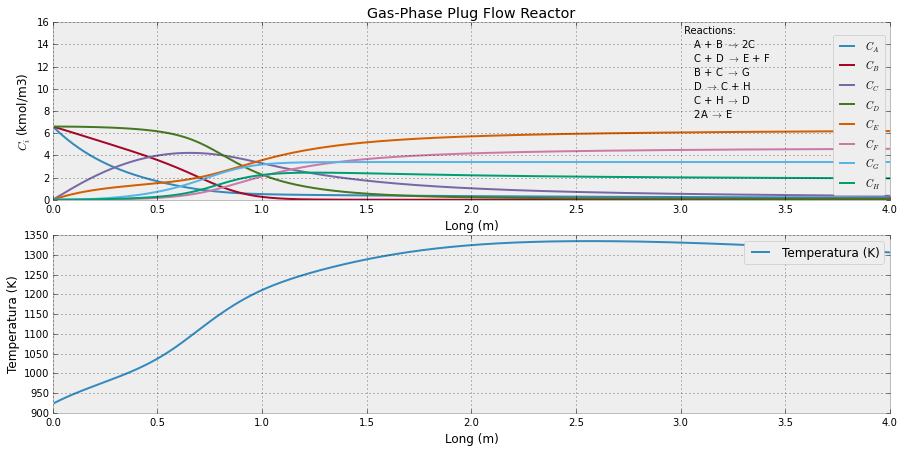

<function __main__.gasPFR>

In [32]:
#Widgets Interactivos

interact(gasPFR,
         C_A0=(0/60, 800/60, 0.1), C_B0=(0/60, 800/60, 0.1),
         C_D0 = (0/60, 800/60, 0.1))

__Bibliografía:__

Apuntes de __"Diseño de Reactores 1"__ de Ingeniería Química - *Examen. Convocatoria de enero de 2014*